In [ ]:
%%bash
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
import math
import time
import nltk
import torch
import string
import random
import unidecode
import numpy as np
import pandas as pd
import torch.nn as nn
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch.autograd import Variable

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else:
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


# Setup:

```
# This is formatted as code
```



In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [ ]:
DEVICE = set_device()
DEVICE

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


'cpu'

## Define RNN Module

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
# torch.onnx.export(model, X_test, 'iris.onnx', input_names=["features"], output_names=["logits"])
# torch.onnx.export(model, 'iris.onnx')

## Helper funcions

In [ ]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
def train(inp, target):
    # hidden = decoder.init_hidden().cuda()
    hidden = decoder.init_hidden().to(DEVICE)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        # output, hidden = decoder(inp[c].cuda(), hidden)
        # loss += criterion(output, target[c].cuda())
        output, hidden = decoder(inp[c].to(DEVICE), hidden)
        loss += criterion(output, target[c].to(DEVICE))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

Text Generation:

In [ ]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    # hidden = decoder.init_hidden().cuda()
    hidden = decoder.init_hidden().to(DEVICE)

    for p in range(predict_len):

        # prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).to(DEVICE)
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
        # inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

# Dataset:

In [ ]:
def data_loader(path):
  data = pd.read_csv(path)
  return data

In [ ]:
def text_selector(data):

  l = len(data)

  data_text = data['text']
  data_label = data['label']

  semantic = ''
  training_data =[]

  for i in range(l):

    if data_label[i] == 1:
      semantic = 'positive '
      data_string_i = data_text[i].replace("USER", "")
      # e = data_string_i.split("  ")
      # training_data.append(semantic + e[-1])
      training_data.append(semantic + data_string_i)

    else:
      semantic = 'negative '
      data_string_i = data_text[i].replace("USER", "")
      # e = data_string_i.split("  ")
      # training_data.append(semantic + e[-1])
      training_data.append(semantic + data_string_i)

  text_data = ' '.join(training_data)
  return text_data

In [ ]:
def clean_text(text):
  stop = set(nltk.corpus.stopwords.words('english'))
  exclude = set(string.punctuation)
  lemma = nltk.stem.wordnet.WordNetLemmatizer()

  def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
  test_sentence = clean(text).lower().split()
  return test_sentence

In [ ]:
# loading the dataset:

# drive.mount('/content/drive')

train_path = "/content/drive/MyDrive/Code/dataset_full/train_split.csv"
val_path = "/content/drive/MyDrive/Code/dataset_full/val_split.csv"
test_path = "/content/drive/MyDrive/Code/dataset_full/test_cleaned.csv"

train_data = data_loader(train_path)
val_data = data_loader(val_path)
test_data = data_loader(test_path)

In [ ]:
data_d = pd.read_csv(train_path)
data_d.head()

,text,label
0,USER ahh closed,0
1,awesome lunch mom amp bro yummy sushi amp udon,1
2,imisscath imisscath imisscath imisscath imissc...,0
3,USER good morning beautiful one,1
4,cracked open first chapter something old new t...,1


In [ ]:
train_data_mini = train_data[:5000]
val_data_mini = val_data[:400]
test_data_mini = test_data[:800]

In [ ]:
train_mini = text_selector(train_data_mini)
val_mini = text_selector(val_data_mini)
test_mini = text_selector(test_data_mini)

In [ ]:
train_data_mini_clean = clean_text(train_mini)
val_data_mini_clean = clean_text(val_mini)
test_data_mini_clean = clean_text(test_mini)

# N-Gram Model:

In [ ]:
"""
N-Gram:  * P(wi|wi−1,wi−2,…,wi−n+1)
"""

trigrams = [([train_data_mini_clean[i], train_data_mini_clean[i + 1]], train_data_mini_clean[i + 2])
            for i in range(len(train_data_mini_clean) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['negative', 'ahh'], 'closed'), (['ahh', 'closed'], 'positive'), (['closed', 'positive'], 'awesome')]


# Training:

In [ ]:
vocab = set(train_data_mini_clean)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [ ]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

In [ ]:
%%time
'''
n_epochs = 300
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.015
'''

n_epochs = 50
print_every = 10
plot_every = 10
hidden_size = 50
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
        #print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 53s (10 10%) 7.0875]
 48s (20 20%) 6.4083]
 42s (30 30%) 5.6365]
 36s (40 40%) 4.8129]
 31s (50 50%) 4.0734]
CPU times: user 29min 20s, sys: 3.23 s, total: 29min 23s
Wall time: 29min 31s


In [ ]:
print(voc_len)

8054


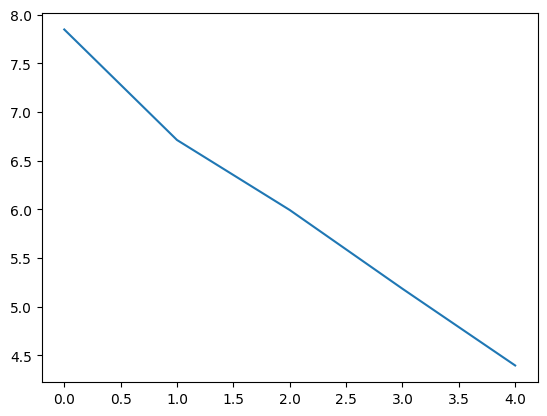

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Saving the model
source: https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
"""
# Assuming 'model' is your PyTorch model
torch.save(model.state_dict(), 'model_state_dict.pth')
model = YourModelClass(*args, **kwargs)
model.load_state_dict(torch.load('model_state_dict.pth'))

"""

In [ ]:
# Save model parameters to a file
# torch.save(decoder.state_dict(), 'RNN-GRU_weights.pth')

In [ ]:
# ! cp /content/RNN-GRU_weights.pth /content/drive/MyDrive/NMA_DL.Project-ZMSP/Code/Text_Generation_N-Gram_RNN

In [ ]:
# Save model parameters to a file
torch.save({'model_state_dict':decoder.state_dict(), 'oprimizaer_state_dict()':decoder_optimizer.state_dict(), 'hyperparameters':{'input_size':voc_len, 'hidden_size':hidden_size, 'output_size':voc_len, 'n_layers':n_layers}, 'training_history': all_losses}, 'chechpoint.pth')

In [ ]:
! cp /content/chechpoint.pth /content/drive/MyDrive/NMA_DL.Project-ZMSP/Code/Text_Generation_N-Gram_RNN

# Generaring Text:

In [ ]:
initi = input("please enter the first word you're going to generate a tweet starting with them:  ")
senti = input("please enter the sentiment of tweet to generate:  ")
starter = senti + ' '+ initi
num = int(input("please enter the length of the tweet you want to generate:  "))

please enter the first word you're going to generate a tweet starting with them:  negative
please enter the sentiment of tweet to generate:  ahh
please enter the length of the tweet you want to generate:  3
